In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from astroML.datasets import sdss_corrected_spectra
import scipy.sparse as sps
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import kneighbors_graph
import rmetric
import coord_search

In [6]:
# adapted from https://github.com/stephenportillo/SDSS-VAE/blob/master/SDSS-VAE.ipynb
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
rawspec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

spec = rawspec / data['norms'][:,None] 
meanspec = np.mean(spec, axis=0)
nfeat = meanspec.size

X = spec - meanspec # Normalize data

### Set Colormap Based on Blue Spectra Magnitude

In [66]:
blue_mask = (lam >= 3000) & (lam <= 4000)
blue_flux = spec[:, blue_mask]
magnitudes = np.mean(blue_flux, axis=1)

cmap = plt.get_cmap('magma')
newcmp = ListedColormap(cmap(np.linspace(0, 7/8, 224))) # Get first 7/8ths of color map to get rid of bright yellow

### Set Colomap Based on Classes of Galaxies

In [ ]:
specclass = data['lineindex_cln']
# stars have lineindex_cln 1, 9
stars = (specclass == 1) + (specclass == 9)
starsidx = np.where(stars)[0]
# map lineindex_cln 2,3 to 0 and 4,5,6 to 1,2,3
specclass -= 3
specclass[specclass == -1] = 0 # set line_index 2 -> 0
specclass[specclass < -1] = -1
specclass[specclass > 3] = -1


colors = [(0., 107/256, 164/256), (255/256, 128/256, 14/256), (89/256, 89/256, 89/256), (171/256, 171/256, 171/256)]

# Uncomment these lines to use these colormaps
# magnitudes = ['quiescent galaxy', 'emission-line galaxy', 'narrow-line AGN', 'broad-line AGN']
# newcmp = ListedColormap(colors)

### Plot a spectra

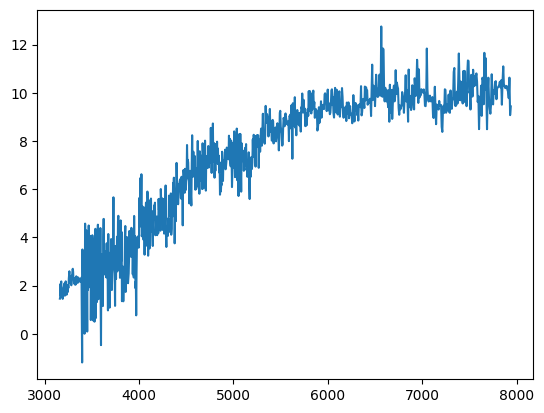

In [10]:
plt.plot(lam, rawspec[4])

### Generate an embedding

In [45]:
# ----------------------------
# Laplacian Eigenmaps (Belkin–Niyogi style)
# ----------------------------
k = 512

# Sparse kNN distance graph (only edges), exclude self-neighbor
G = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

s = 100

# Heat kernel weights on edges
G.data = np.exp(-(G.data**2) / (2 * (s ** 2)))

# Symmetrize W (undirected graph)
W = 0.5 * (G + G.T)

# Degree and Laplacian (sparse)
d = np.asarray(W.sum(axis=1)).ravel() + 1e-8
D = sps.diags(d)
L = D - W

# Generalized eigenproblem: (D - W) v = λ D v
# Compute smallest eigenpairs: need 1 extra to drop the trivial eigenvector
vals, vecs = eigsh(L, M=D, which='SM')  # SM = smallest magnitude
idx = np.argsort(vals)
vals, vecs = vals[idx], vecs[:, idx]

X_le = vecs[:, 1:]

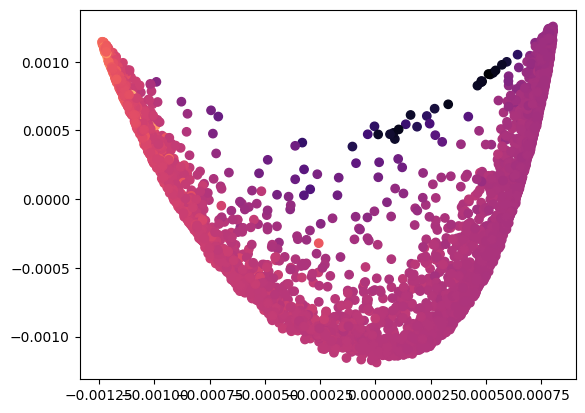

In [67]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_le[:, 0], X_le[:, 1], c=magnitudes, cmap=newcmp)
plt.show()

### Get optimal axis using Independent Eigendirection Selection

In [68]:
H, U, S = rmetric.riemannian_metric(X_le, L)

opt_proj_axis = coord_search.greedy_coordinate_search(
        U, 2, S, zeta=1)

print(opt_proj_axis)

[np.int64(0), np.int64(2)]


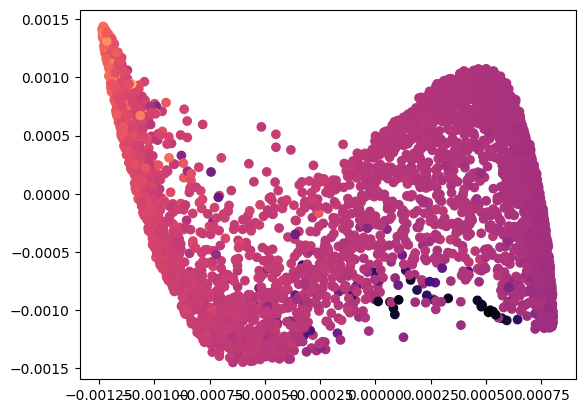

In [69]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_le[:, opt_proj_axis[0]], X_le[:, opt_proj_axis[1]], c=magnitudes, cmap=newcmp)
plt.show()

### Generate Eigenvectors for Different $k$ and $s$

In [32]:
ks = [8, 32, 128, 512]
ss = [0.1, 1, 10, 100]

vals_list = []
vecs_list = []

for i in range(len(ks) * len(ss)):
    # ----------------------------
    # Laplacian Eigenmaps (Belkin–Niyogi style)
    # ----------------------------
    k = ks[i // len(ss)]

    # Sparse kNN distance graph (only edges), exclude self-neighbor
    G = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

    # Choose bandwidth s ~ median kNN distance (robust)
    s = ss[i % len(ss)]
    print(f"Generating eigenvectors for k: {k}, s: {s}")

    # Heat kernel weights on edges
    G.data = np.exp(-(G.data**2) / (2 * (s ** 2)))

    # Symmetrize W (undirected graph)
    W = 0.5 * (G + G.T)

    # Degree and Laplacian (sparse)
    d = np.asarray(W.sum(axis=1)).ravel() + 1e-8
    D = sps.diags(d)
    L = D - W

    # Generalized eigenproblem: (D - W) v = λ D v
    # Compute smallest eigenpairs: need 1 extra to drop the trivial eigenvector
    vals, vecs = eigsh(L, M=D, which='SM')  # SM = smallest magnitude
    idx = np.argsort(vals)
    vals, vecs = vals[idx], vecs[:, idx]

    vals_list.append(vals)
    vecs_list.append(vecs)

Generating eigenvectors for k: 8, s: 0.1
Generating eigenvectors for k: 8, s: 1
Generating eigenvectors for k: 8, s: 10
Generating eigenvectors for k: 8, s: 100
Generating eigenvectors for k: 32, s: 0.1
Generating eigenvectors for k: 32, s: 1
Generating eigenvectors for k: 32, s: 10
Generating eigenvectors for k: 32, s: 100
Generating eigenvectors for k: 128, s: 0.1
Generating eigenvectors for k: 128, s: 1
Generating eigenvectors for k: 128, s: 10
Generating eigenvectors for k: 128, s: 100
Generating eigenvectors for k: 512, s: 0.1
Generating eigenvectors for k: 512, s: 1
Generating eigenvectors for k: 512, s: 10
Generating eigenvectors for k: 512, s: 100


### Generate plot function

In [76]:
def generate_plots(first_eigvec, second_eigvec): 
    """
    Generate plots with the eigenvectors of first_eigenvec and second_eigenvec,
    where the zero index starts from the non-trivial eigenvector.

    Parameters
    -------------
    :param first_eigvec: First eigenvector as first dimension
    :param second_eigvec: Second eigenvector as second dimension
    """
    # Add figure
    fig = plt.figure(figsize=(len(ss) * 5, len(ks) * 5))
    fig.tight_layout()

    for i in range(len(ks) * len(ss)):    
        k = ks[i // len(ss)]
        s = ss[i % len(ss)]
        X_le = vecs_list[i][:, 1:]  # drop trivial constant eigenvector
        ax = fig.add_subplot(len(ks), len(ss), i+1)
        ax.scatter(X_le[:, first_eigvec], X_le[:, second_eigvec], c=magnitudes, cmap=newcmp,
                   s=10, linewidths=0)

        if i % len(ss) == 0:
            ax.set_ylabel(f'k = {k}')
        if i // len(ss) == len(ks) - 1:
            ax.set_xlabel(f's = {s}')

    plt.savefig(f'../figures/galaxy_spectra_different_hyp_vec_{first_eigvec + 1}&{second_eigvec + 1}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

### Generate Plot for First and Second Eigenvectors

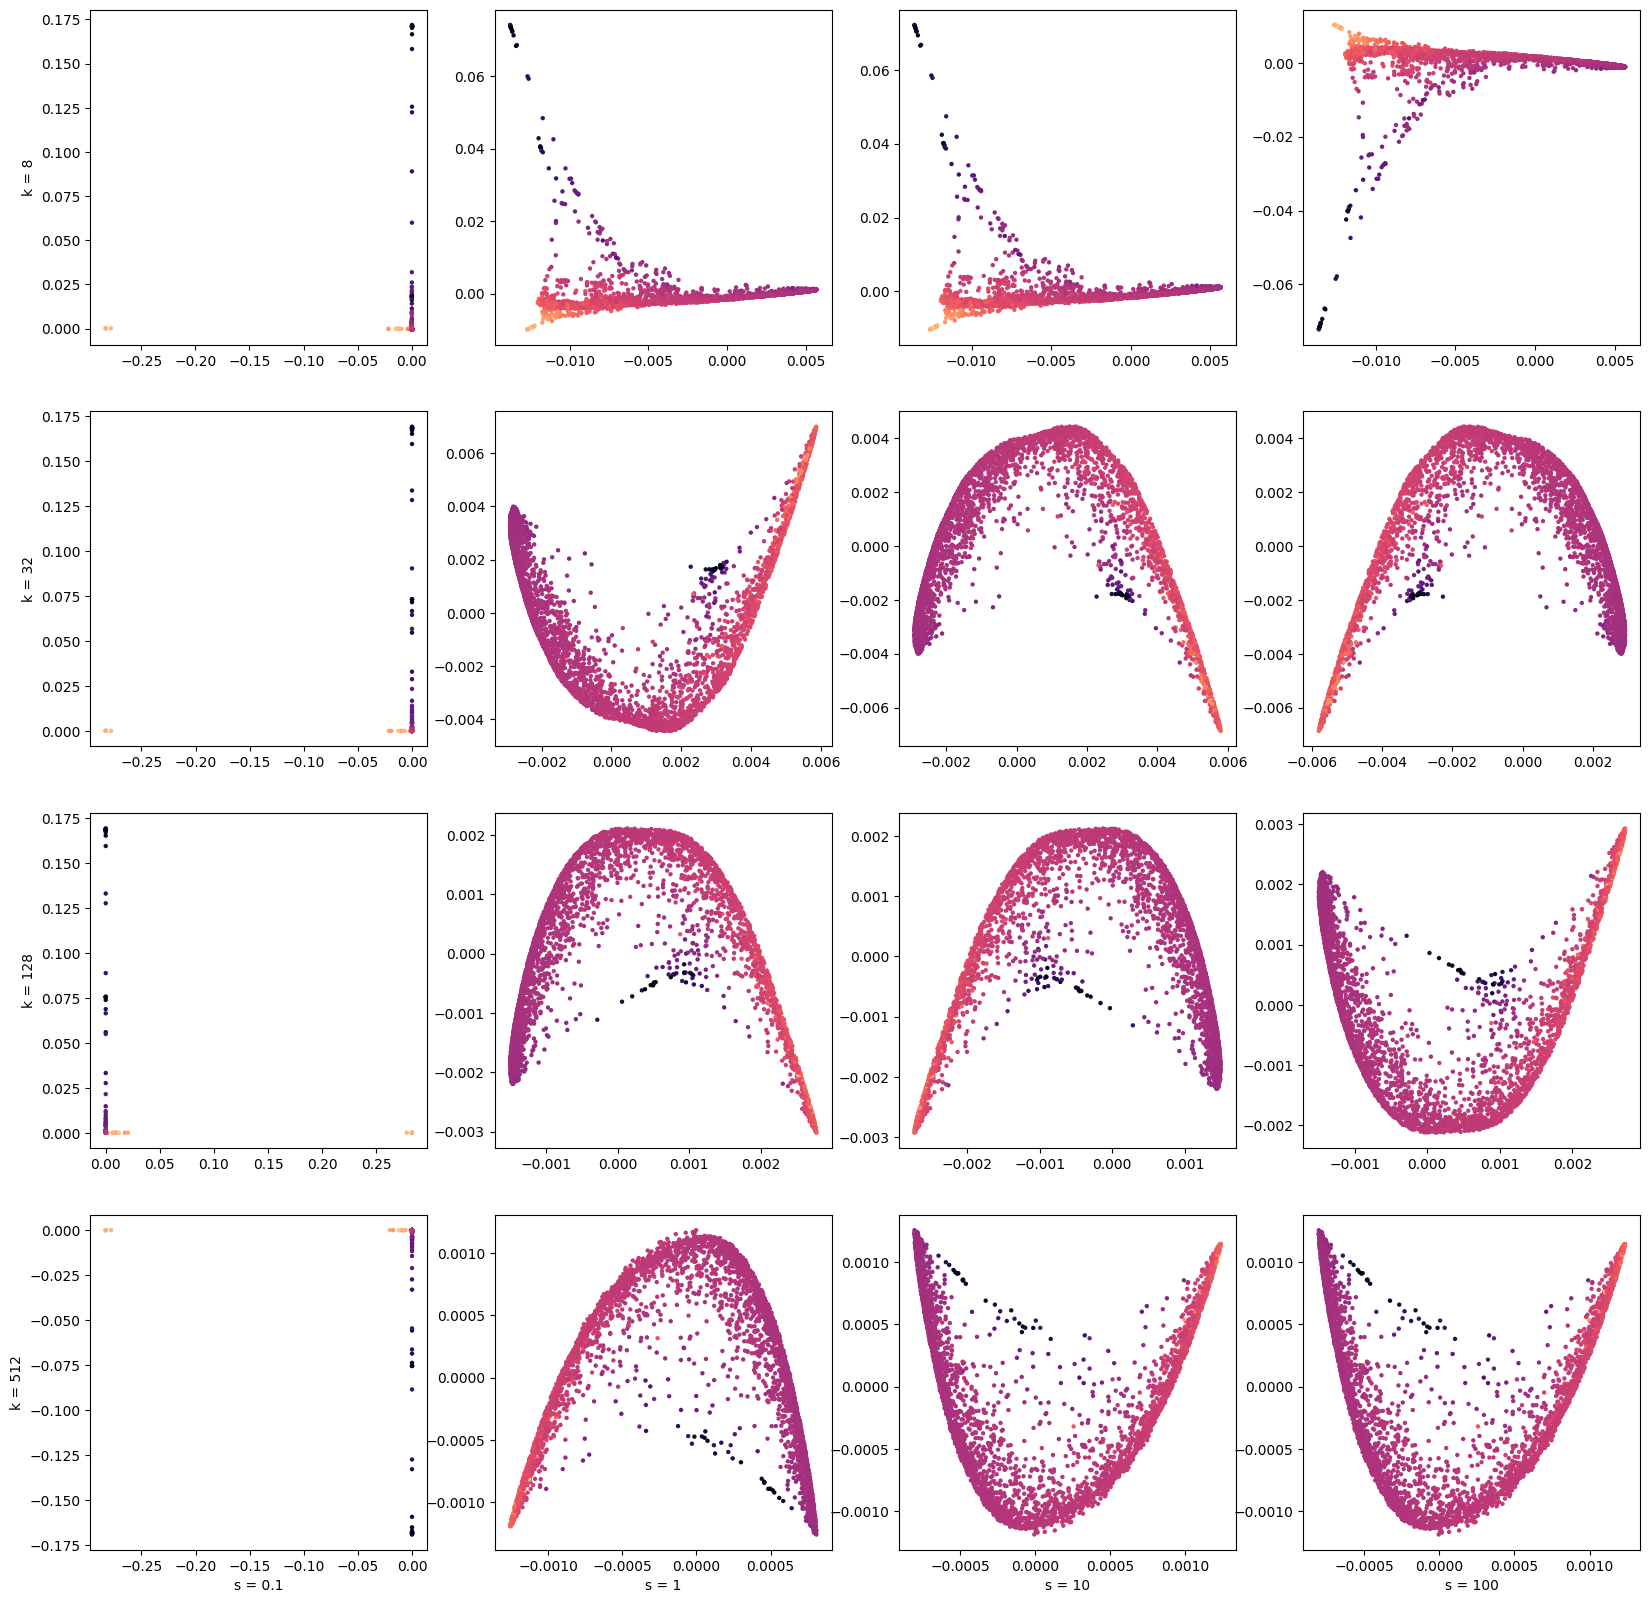

In [77]:
generate_plots(0, 1)

### Generate Plot for First and Third Eigenvectors

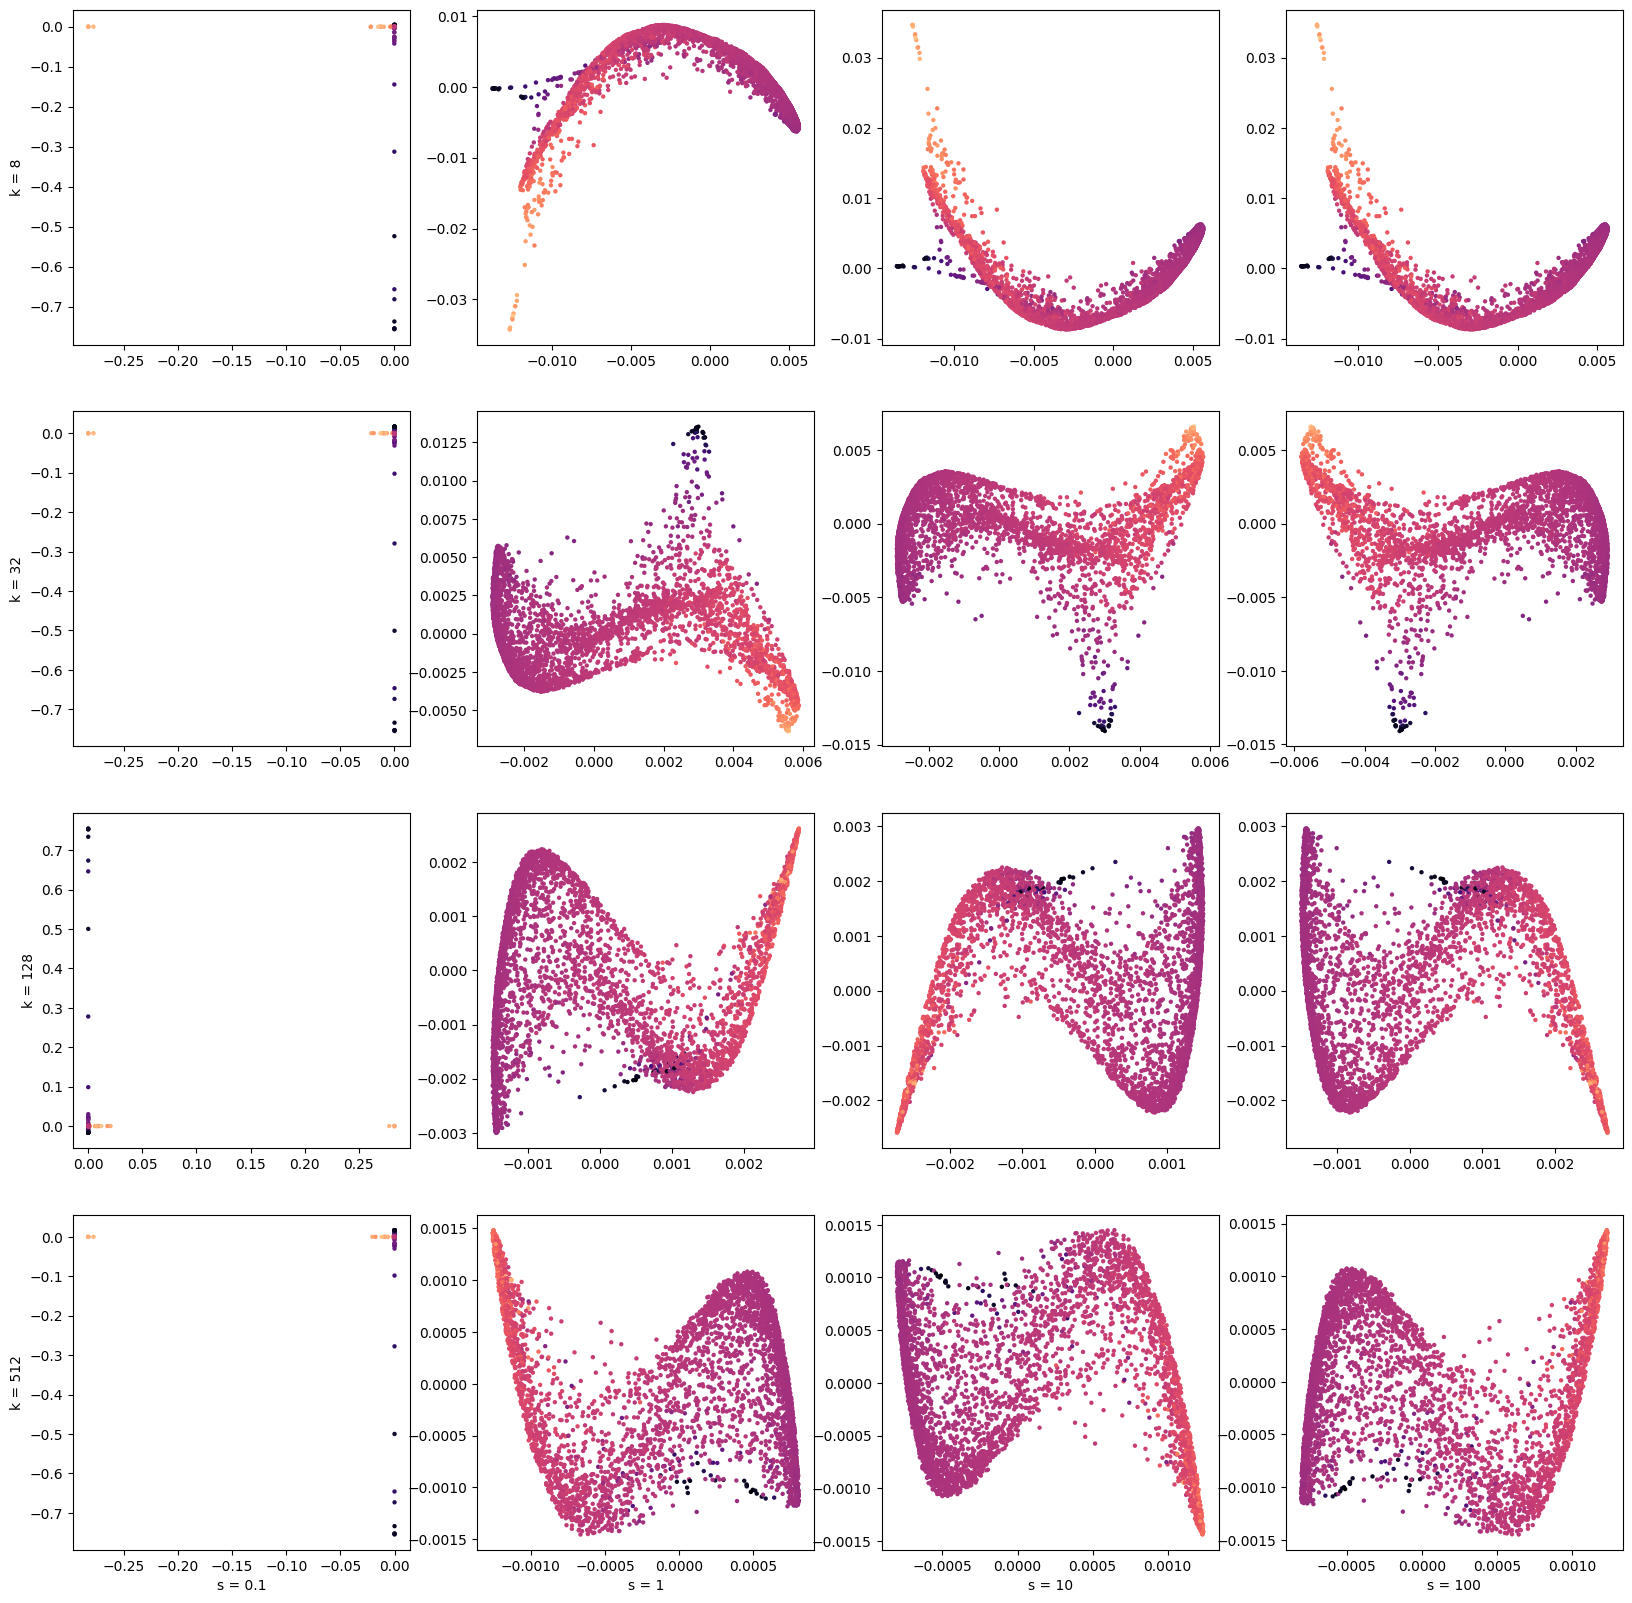

In [72]:
generate_plots(0, 2)

### Generate Plots for First and Fourth Eigenvectos

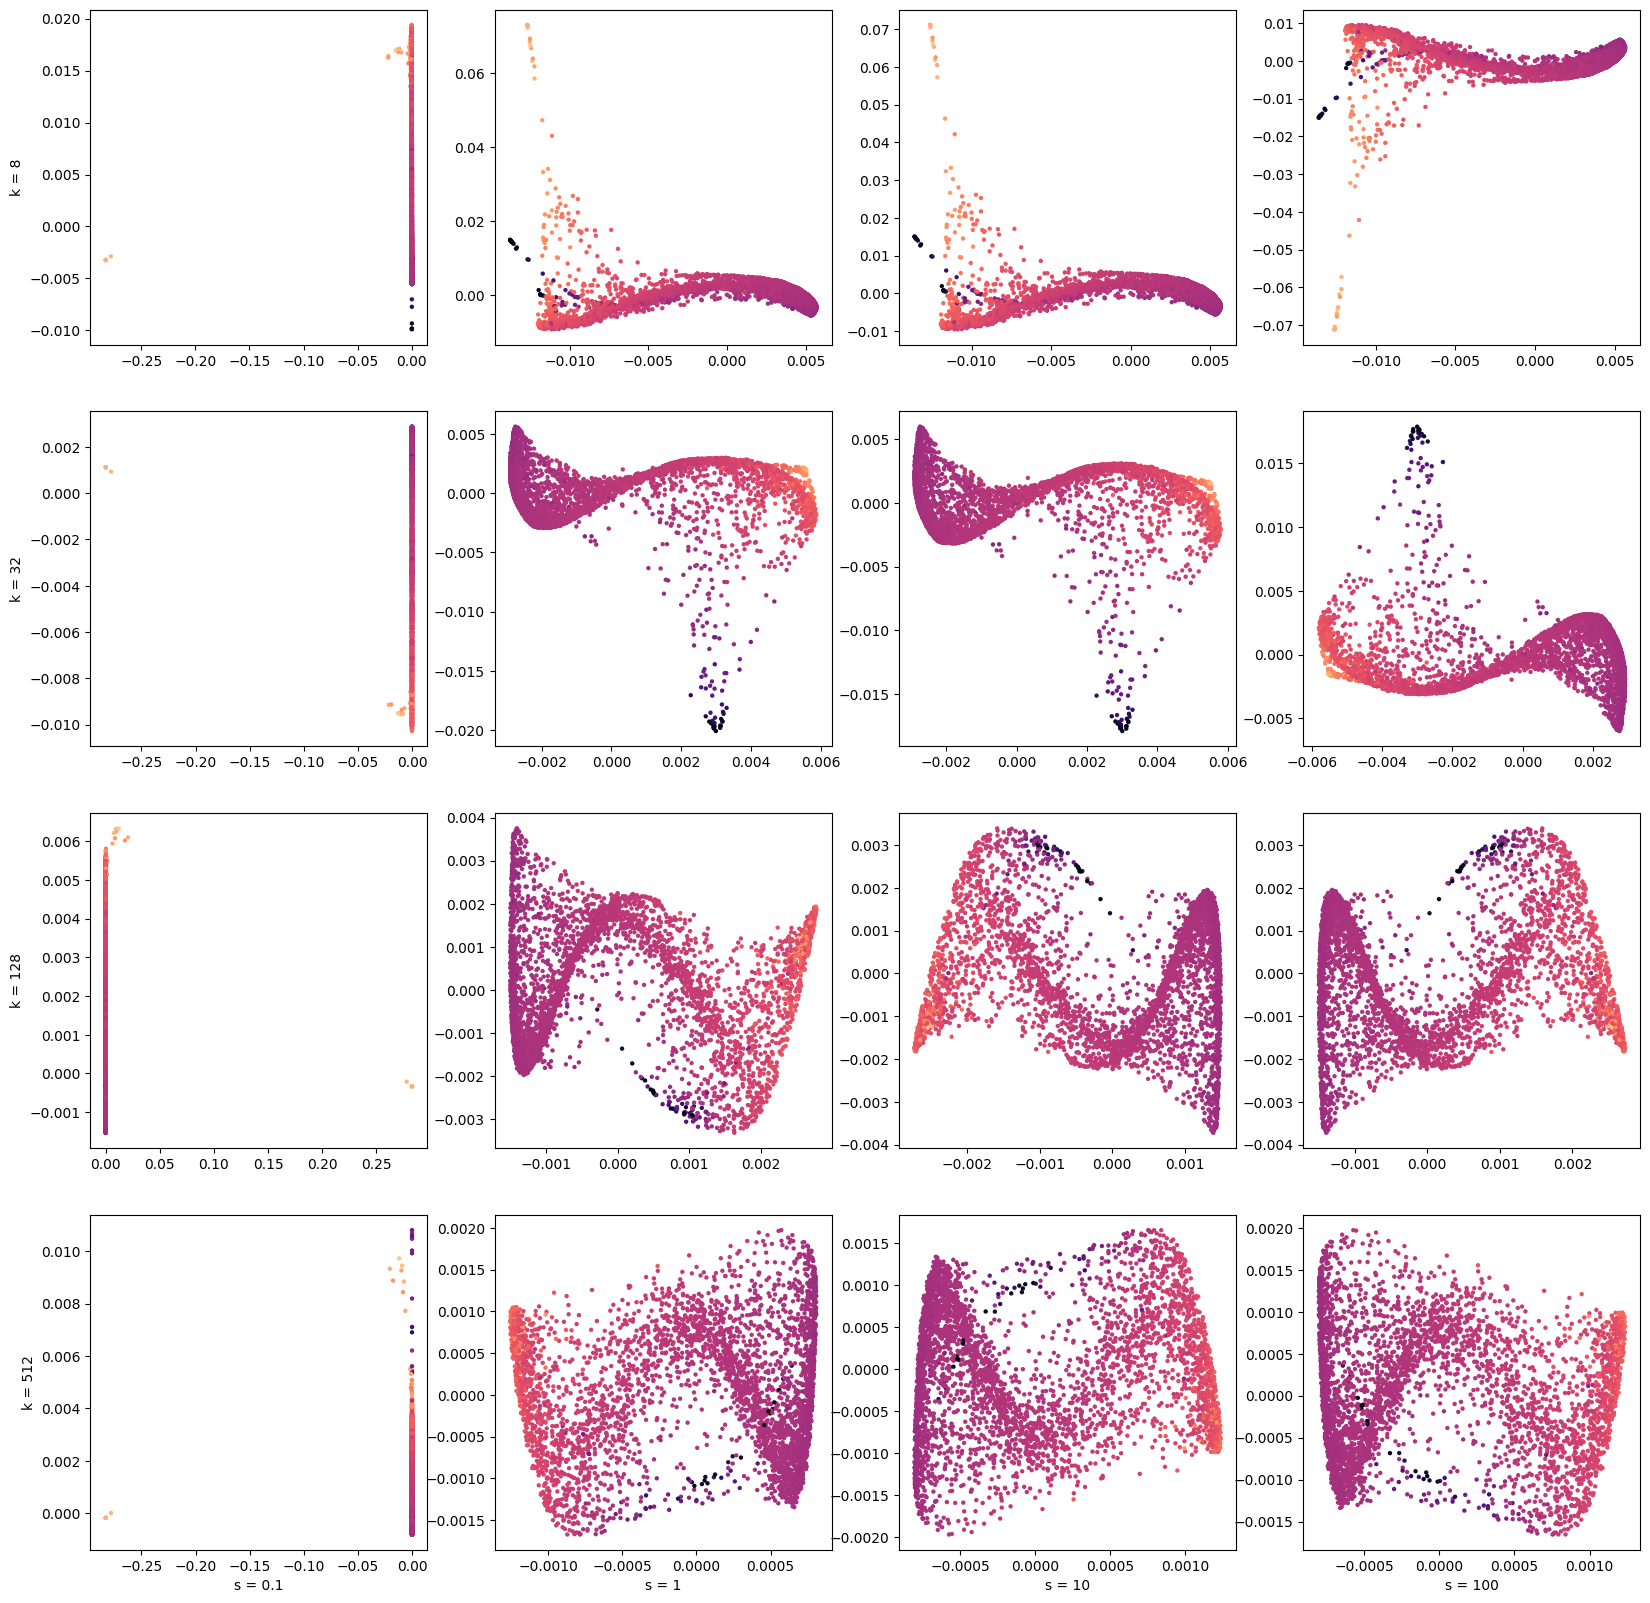

In [75]:
generate_plots(0, 3)

In [37]:
def generate_plots_optimal_axes(): 
    """
    Generate plots with optimal eigenvectors chosen through independent eigendirection selection.
    """
    # Add figure
    fig = plt.figure(figsize=(len(ss) * 5, len(ks) * 5))
    fig.tight_layout()

    for i in range(len(ks) * len(ss)):    
        k = ks[i // len(ss)]
        s = ss[i % len(ss)]
        X_le = vecs_list[i][:, 1:]  # drop trivial constant eigenvector
        ax = fig.add_subplot(len(ks), len(ss), i+1)

        H, U, S = rmetric.riemannian_metric(X_le, L)

        opt_proj_axis = coord_search.greedy_coordinate_search(
                U, 2, S, zeta=1)

        ax.scatter(X_le[:, opt_proj_axis[0]], X_le[:, opt_proj_axis[1]], c=magnitudes, cmap=newcmp,
                   s=5, linewidths=0)

        if i % len(ss) == 0:
            ax.set_ylabel(f'k = {k}')
        if i // len(ss) == len(ks) - 1:
            ax.set_xlabel(f's = {s}')

    plt.savefig(f'../figures/galaxy_spectra_different_hyp_opt_vec.png')
    plt.show()


/home/anthony/Projects/laplacian_eigenmaps/code/coord_search.py:14: RuntimeWarning: invalid value encountered in sqrt
  parallelepipe_vol = np.sqrt(vol_sq)


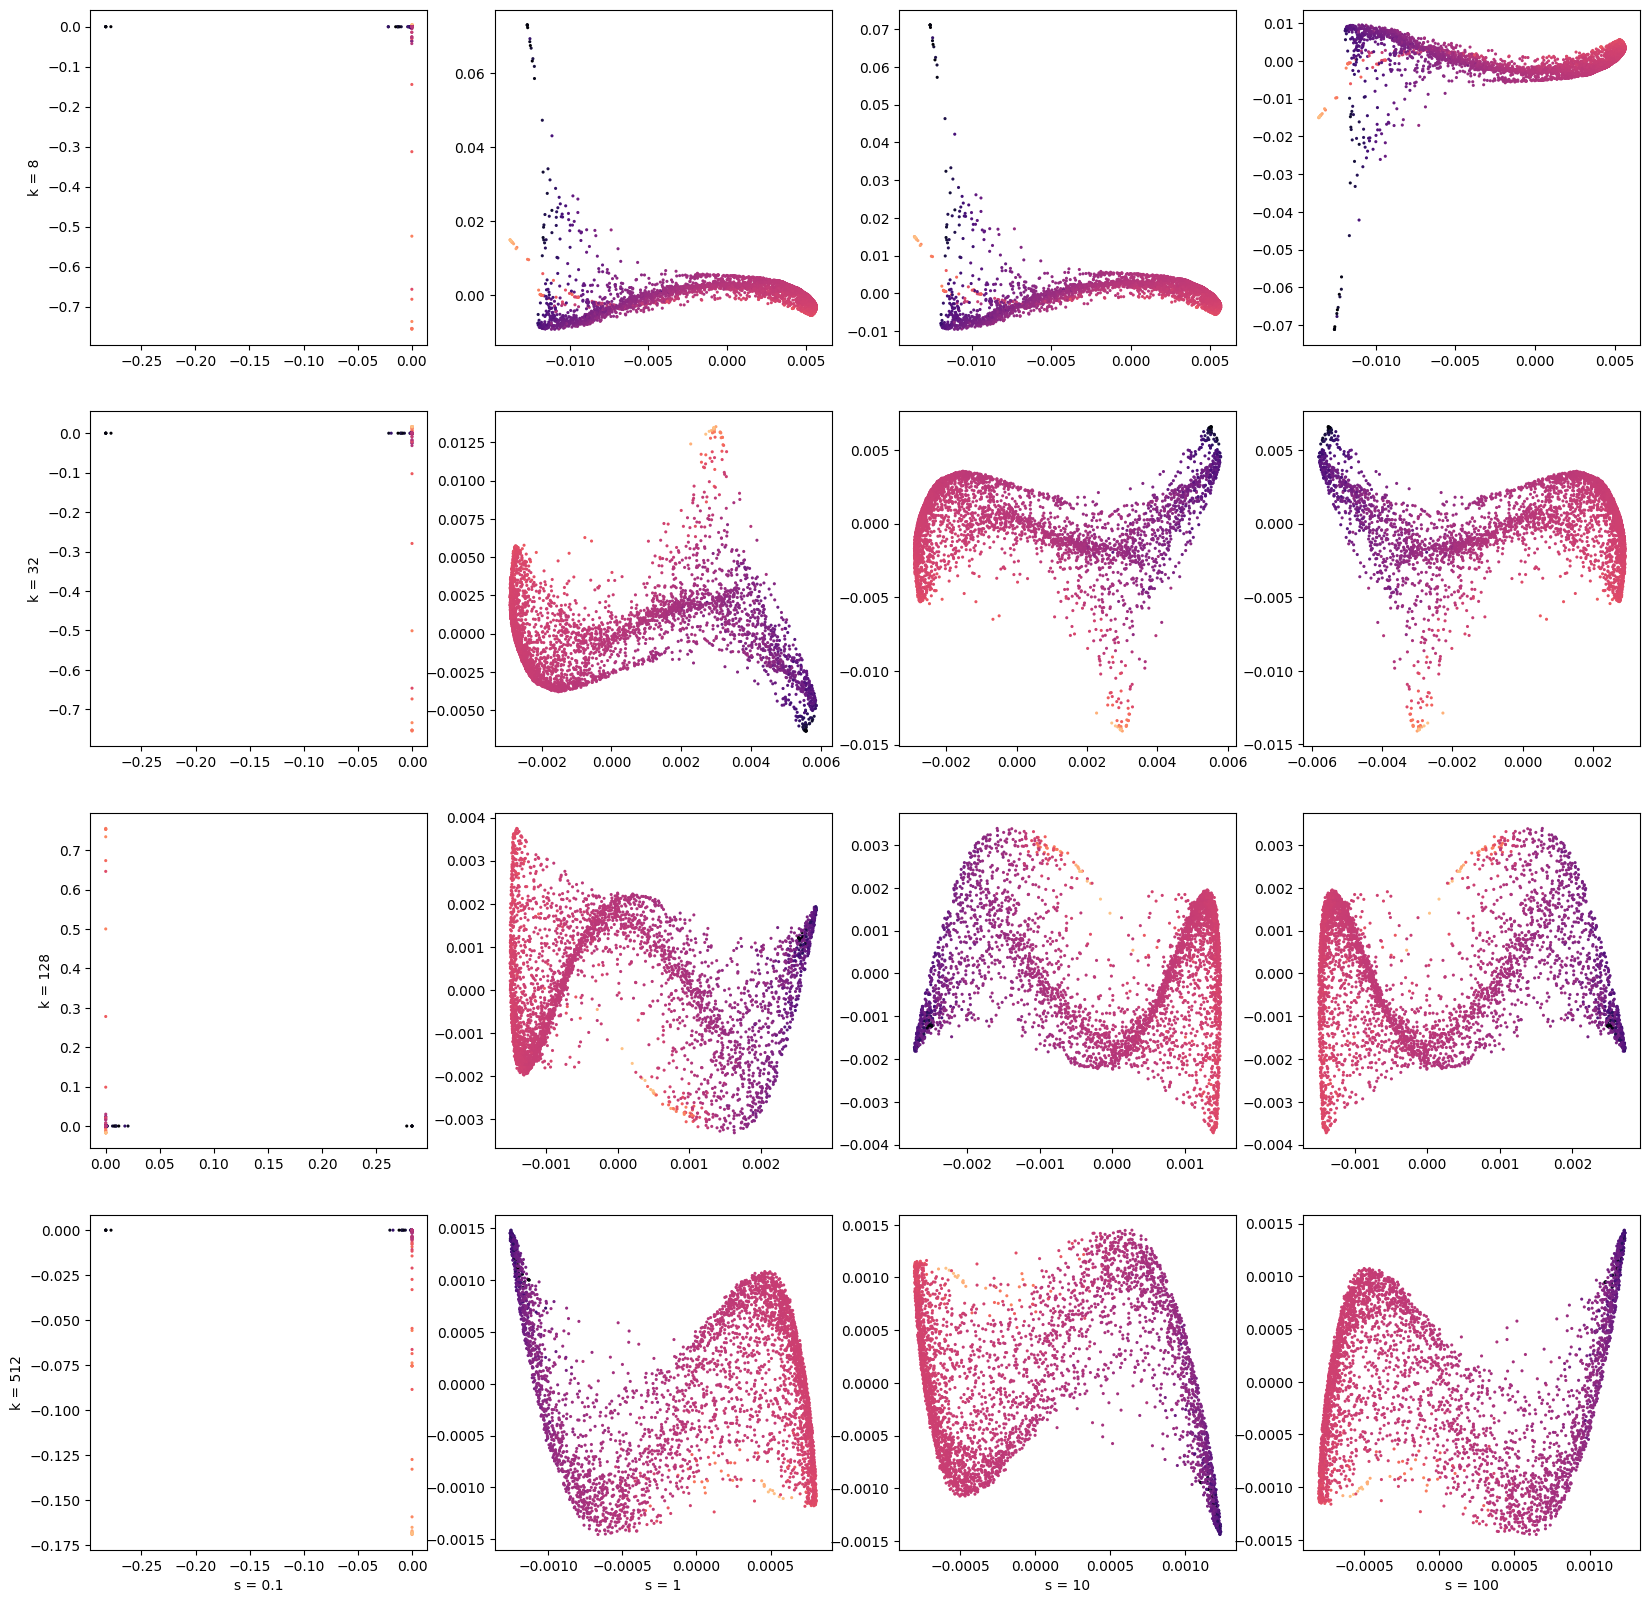

In [38]:
generate_plots_optimal_axes()